In [1]:

import numpy as np
import cv2
import os

import pickle
from joblib import dump, load

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.utils import shuffle
from sklearn import linear_model




In [ ]:
# Load the images from the dataset and resize them to around mean size (840)
def read_and_return_img_list(dset="train"):

  dataset_path = "C:\\Users\\Srinivas\\Downloads\\Dataset-Pneumonia\\chest_xray"
  dataset_path = os.path.join(dataset_path, dset)

  img_list_1 = []
  img_list_0 = []

  for idx, filename in enumerate(os.listdir(dataset_path + "\\" + "PNEUMONIA")):

    img_path = dataset_path + "\\" + "PNEUMONIA" + "\\" + filename
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Do image pre processing here
    resized = resize_image(img, new_dim=(840, 840))


    #print("Done reading " + str(idx))
    img_list_1.append(resized)

  for idx, filename in enumerate(os.listdir(dataset_path + "\\" + "NORMAL")):

    img_path = dataset_path + "\\" + "NORMAL" + "\\" + filename
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Do image pre processing here
    resized = resize_image(img, new_dim=(840, 840))


    #print("Done reading " + str(idx))
    img_list_0.append(resized)

  return img_list_0, img_list_1 
  
def resize_image(img, new_dim=(840, 840)):
  
  resized = cv2.resize(img,  new_dim, interpolation = cv2.INTER_AREA)
  return resized 


In [ ]:

# Getting the image pixels
img_list_train_0, img_list_train_1 = read_and_return_img_list("train")
img_list_val_0, img_list_val_1 = read_and_return_img_list("val")
img_list_test_0, img_list_test_1 = read_and_return_img_list("test")


#Note that earlier we had not yet resized and decision to recize was based on this mean value.
np.mean([img.shape[0] for img in img_list_train_0])

In [54]:
#Combining the data for the different labels and converting to a numpy array
image_list_train = []
image_list_val = []
image_list_test = []



image_list_train.extend(img_list_train_0)
image_list_train.extend(img_list_train_1)

image_list_val.extend(img_list_val_0)
image_list_val.extend(img_list_val_1)

image_list_test.extend(img_list_test_0)
image_list_test.extend(img_list_test_1)



image_np_train = np.zeros(shape=((len(image_list_train), image_list_train[0].shape[0], image_list_train[0].shape[1])))
image_np_val = np.zeros(shape=(len(image_list_val), image_list_val[0].shape[0], image_list_val[0].shape[1]))
image_np_test = np.zeros(shape=((len(image_list_test), image_list_test[0].shape[0], image_list_test[0].shape[1])))

for i in range(len(image_list_train)):
    for j in range(image_list_train[0].shape[0]):
        for k in range(image_list_train[0].shape[1]):
            image_np_train[i][j][k] = image_list_train[i][j][k]

for i in range(len(image_list_val)):
    for j in range(image_list_val[0].shape[0]):
        for k in range(image_list_val[0].shape[1]):
            image_np_val[i][j][k] = image_list_val[i][j][k]

for i in range(len(image_list_test)):
    for j in range(image_list_test[0].shape[0]):
        for k in range(image_list_test[0].shape[1]):
            image_np_test[i][j][k] = image_list_test[i][j][k]


y_0 = np.zeros(len(img_list_train_0))
y_1 = np.ones(len(img_list_train_1))
y_np_train = np.concatenate((y_0, y_1), axis=0)

y_0 = np.zeros(len(img_list_val_0))
y_1 = np.ones(len(img_list_val_1))
y_np_val = np.concatenate((y_0, y_1), axis=0)

y_0 = np.zeros(len(img_list_test_0))
y_1 = np.ones(len(img_list_test_1))
y_np_test = np.concatenate((y_0, y_1), axis=0)



# Saving th images numpy arrays
np.save("image_np_train.npy", image_np_train)
np.save("image_np_val.npy", image_np_val)
np.save("image_np_test.npy", image_np_test)

# Saving the labels numpy arrays
np.save("y_train.npy", y_np_train)
np.save("y_val.npy", y_np_val)
np.save("y_test.npy", y_np_test)



In [2]:
#Load all the images from numpy array files

X_train = np.load("C:\\Users\\Srinivas\\OneDrive\\Desktop\\CVProjs\\image_np_train.npy")
y_train = np.load("C:\\Users\\Srinivas\\OneDrive\\Desktop\\CVProjs\\y_train.npy")

X_val = np.load("C:\\Users\\Srinivas\\OneDrive\\Desktop\\CVProjs\\image_np_val.npy")
y_val = np.load("C:\\Users\\Srinivas\\OneDrive\\Desktop\\CVProjs\\y_val.npy")

X_test = np.load("C:\\Users\\Srinivas\\OneDrive\\Desktop\\CVProjs\\image_np_test.npy")
y_test = np.load("C:\\Users\\Srinivas\\OneDrive\\Desktop\\CVProjs\\y_test.npy")


In [ ]:
#Do Required Pre Processing and data augmentation techniques

In [3]:
# Saving and Restoring the model
# NOte name has to be of the format name.joblib
def save_model(model, save_name):
    dump(model, save_name)

def load_model(model_name):
    return load(model_name)

In [14]:
nSamples , nx, ny = X_train.shape
X_train = X_train.reshape((nSamples, nx*ny))
# Need shuffling as we can't have only one label type in a single batch.
X_train, y_train = shuffle(X_train, y_train)


nSamples , nx, ny = X_val.shape
X_val = X_val.reshape((nSamples, nx*ny))

nSamples , nx, ny = X_test.shape
X_test = X_test.reshape((nSamples, nx*ny))

In [11]:
def train_model(X, y, batch_size, model_configuration):
    
    start_index = 0
    end_index = start_index + batch_size

    clf = linear_model.SGDClassifier(**model_configuration)


    while (start_index < len(y)):
        
        
        X_batch = X[start_index:end_index]
        y_batch = y[start_index:end_index]

        print("Training the %s th batch of ~ %s" % (start_index/batch_size, len(y)//batch_size))

        clf.fit(X_batch, y_batch)

        start_index = end_index 
        end_index = min(len(y), start_index + batch_size)
    
    return clf


def test_model(clf, X, y):
    y_hat = clf.predict(X)
    visualize_results(clf, X, y, y_hat)

def visualize_results(clf, X, y, y_hat):

    y_normal = y == 0
    y_pneumonia = y == 1

    y_hat_normal = y_hat == 0
    y_hat_pneumonia = y_hat == 1


    M = confusion_matrix(y_normal, y_hat_normal)
    tn, fp, fn, tp = M.ravel() 

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(" Normal: Precision: %s and recall is %s " % (precision, recall))


    M = confusion_matrix(y_pneumonia, y_hat_pneumonia)
    tn, fp, fn, tp = M.ravel() 

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(" Pneumonia: Precision: %s and recall is %s " % (precision, recall))


    # plotting the confusion matrix
    plot_confusion_matrix(clf, X, y)
    plt.show()

    





In [17]:
model_configuration = {
    'penalty' : 'elasticnet',
    'alpha' : 0.0001,
    'l1_ratio': 0,
    'fit_intercept': True,
    'warm_start' :True,
    'early_stopping': False
}

Training the 0.0 th batch of ~ 163
Training the 1.0 th batch of ~ 163
Training the 2.0 th batch of ~ 163
Training the 3.0 th batch of ~ 163
Training the 4.0 th batch of ~ 163
Training the 5.0 th batch of ~ 163
Training the 6.0 th batch of ~ 163
Training the 7.0 th batch of ~ 163
Training the 8.0 th batch of ~ 163
Training the 9.0 th batch of ~ 163
Training the 10.0 th batch of ~ 163
Training the 11.0 th batch of ~ 163
Training the 12.0 th batch of ~ 163
Training the 13.0 th batch of ~ 163
Training the 14.0 th batch of ~ 163
Training the 15.0 th batch of ~ 163
Training the 16.0 th batch of ~ 163
Training the 17.0 th batch of ~ 163
Training the 18.0 th batch of ~ 163
Training the 19.0 th batch of ~ 163
Training the 20.0 th batch of ~ 163
Training the 21.0 th batch of ~ 163
Training the 22.0 th batch of ~ 163
Training the 23.0 th batch of ~ 163
Training the 24.0 th batch of ~ 163
Training the 25.0 th batch of ~ 163
Training the 26.0 th batch of ~ 163
Training the 27.0 th batch of ~ 163
Tr

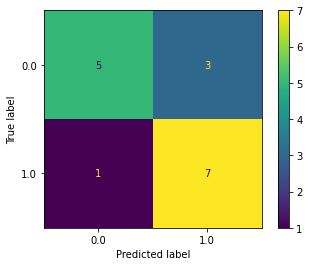

 Normal: Precision: 0.7861271676300579 and recall is 0.5811965811965812 
 Pneumonia: Precision: 0.7827050997782705 and recall is 0.9051282051282051 


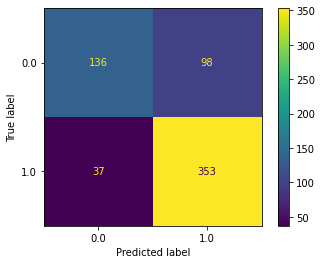

In [18]:
batch_size = 32


#First train the model.

clf = train_model(X_train, y_train, batch_size, model_configuration)
save_model(clf, "sgd_svm_pnm_cls.joblib")

#Validation for better hyper parameter tuning
test_model(clf, X_val, y_val)

# Now do required tuning
#Test out the model on test set
test_model(clf, X_test, y_test)

